### **Lấy ảnh đầu vào**

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  # draw face bounding box on image
  # for (x,y,w,h) in faces:
  #     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


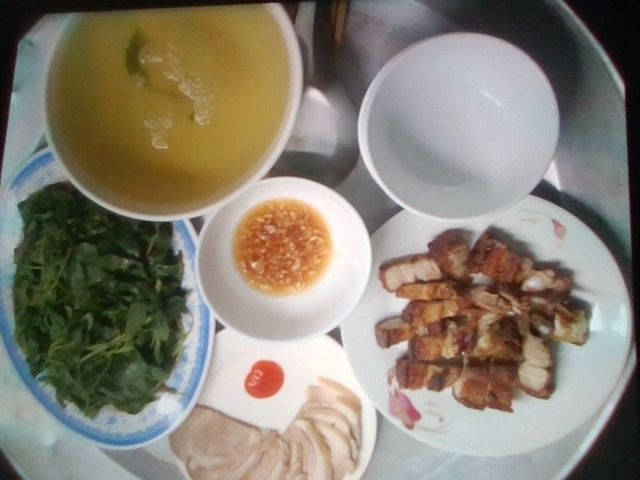

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Detect

### **Gọi model đã train**

In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from ultralytics import YOLO

In [ ]:
model = YOLO("/content/drive/MyDrive/model_trained_seminar/last.pt")

In [ ]:
results = model.predict("/content/photo.jpg")


image 1/1 /content/photo.jpg: 480x640 1 canh_rau, 1 rau_luoc, 1 thit_lon_luoc, 1 thit_lon_ran, 132.5ms
Speed: 2.6ms preprocess, 132.5ms inference, 3188.0ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
result = results[0]

In [ ]:
box = result.boxes[0]

In [ ]:
for box in result.boxes:
  class_id = result.names[box.cls[0].item()]
  cords = box.xyxy[0].tolist()
  cords = [round(x) for x in cords]
  conf = round(box.conf[0].item(), 2)
  print("Object type:", class_id)
  print("Coordinates:", cords)
  print("Probability:", conf)
  print("---")

Object type: rau_luoc
Coordinates: [0, 180, 203, 438]
Probability: 0.93
---
Object type: canh_rau
Coordinates: [32, 1, 307, 217]
Probability: 0.87
---
Object type: thit_lon_ran
Coordinates: [363, 220, 601, 432]
Probability: 0.86
---
Object type: thit_lon_luoc
Coordinates: [171, 374, 372, 480]
Probability: 0.73
---


In [ ]:
plot = results[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)

array([[[ 8, 14, 10],
        [ 8, 14, 10],
        [ 8, 14, 10],
        ...,
        [ 3,  3,  1],
        [ 2,  2,  0],
        [ 2,  2,  0]],

       [[ 8, 14, 10],
        [ 8, 14, 10],
        [ 8, 14, 10],
        ...,
        [ 3,  3,  1],
        [ 2,  2,  0],
        [ 2,  2,  0]],

       [[ 8, 14, 10],
        [ 8, 14, 10],
        [ 8, 14, 10],
        ...,
        [ 3,  3,  1],
        [ 3,  3,  1],
        [ 2,  2,  0]],

       ...,

       [[17, 21, 24],
        [18, 22, 23],
        [18, 24, 24],
        ...,
        [16, 18, 17],
        [15, 17, 16],
        [14, 16, 15]],

       [[18, 22, 23],
        [18, 22, 21],
        [17, 23, 21],
        ...,
        [17, 19, 18],
        [16, 18, 17],
        [16, 18, 17]],

       [[18, 22, 21],
        [18, 22, 21],
        [16, 22, 20],
        ...,
        [17, 19, 18],
        [18, 20, 19],
        [18, 20, 19]]], dtype=uint8)
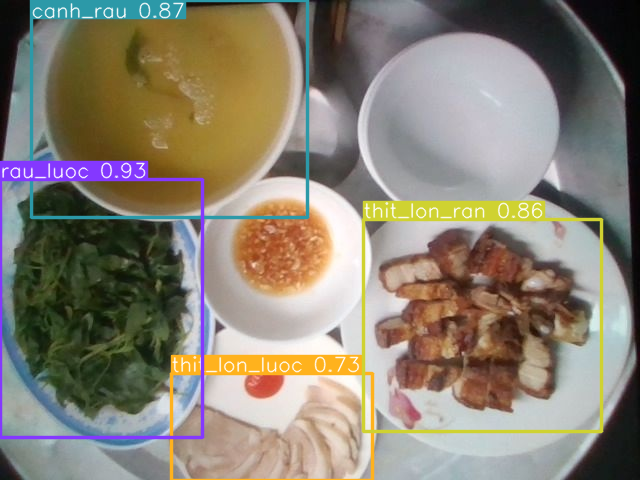

In [ ]:
plot

### **Phân vào chất dinh dưỡng**

In [ ]:
food_names = []
for box in result.boxes:
  class_id = result.names[box.cls[0].item()]
  food_names.append(class_id)

In [ ]:
food_names

['rau_luoc', 'canh_rau', 'thit_lon_ran', 'thit_lon_luoc']

In [ ]:
nutrition_in_food = {
    'chat_dam':['ga_ran','bun_pho_mi_nuoc','trung_luoc','cua','nem','xuc_xich','thit_lon_ran',
                'trung_op_la','ga_nuong','thit_bo_kho','canh_thit','tom','rau_xao_thit','dau_ran',
                'ca_kho','ca_hoi','thit_lon_kho','ga_luoc','ca_ran','dau_trang',
                'thit_lon_luoc','trung_ran','steak','lac_rang','banh_mi_nhan'],
    'chat_duong_bot':['com','bun_pho_mi_nuoc','banh_mi_khong','pizza','khoai','bun_pho_mi_xao','chao','banh_mi_nhan'],
    'chat_beo':['ga_ran','bun_pho_mi_nuoc','pizza','thit_lon_ran','bun_pho_mi_xao','ga_nuong',
                'thit_bo_kho','canh_thit','bo_sua_phomai','rau_xao_thit','dau_ran','ca_kho','thit_lon_kho',
                'ca_ran','thit_lon_luoc','trung_ran','steak','lac_rang'],
    'vitamin_khoangchat':['rau','bun_pho_mi_nuoc','qua_dau_tay','ca_rot','qua_oi','qua_chuoi','cam_buoi','canh_rau','salad',
                          'ngo', 'qua_dua_hau','qua_kiwi','qua_tao','qua_thanh_long','qua_nho','qua_xoai','canh_thit','qua_dua',
                          'rau_xao_thit','rau_song','canh_rau','ca_phao','banh_mi_nhan']
}

In [ ]:
shortage = []
for key, values in nutrition_in_food.items():
    found = False
    for value in values:
        if value in food_names:
            found = True
            break
    if not found:
        shortage.append(key)

if len(shortage) == 0:
  print("Bạn đã có một bữa ăn đủ chất")
else:
  print('Hãy bổ sung thêm các món ăn có chứa các chất dinh dưỡng sau để có một bữa ăn chất lượng hơn nhé:')
  for i in shortage:
    if i =='chat_duong_bot':
      print('Chất đường bột')
    elif i == 'chat_dam':
      print('Chất đạm')
    elif i == 'chat_beo':
      print('Chất béo')
    else:
      print('Vitamin và khoáng chất')

Hãy bổ sung thêm các món ăn có chứa các chất dinh dưỡng sau để có một bữa ăn chất lượng hơn nhé:
Chất đường bột
